In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
from scipy import interpolate
from qmsc.ansatz import FlexibleAnsatz
import qiskit
import fnmatch
import io

In [2]:
matplotlib.style.use("./style.mplstyle")
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}\usepackage{amsfonts}")
#matplotlib.verbose.level = 'debug-annoying'

# Bures data plots

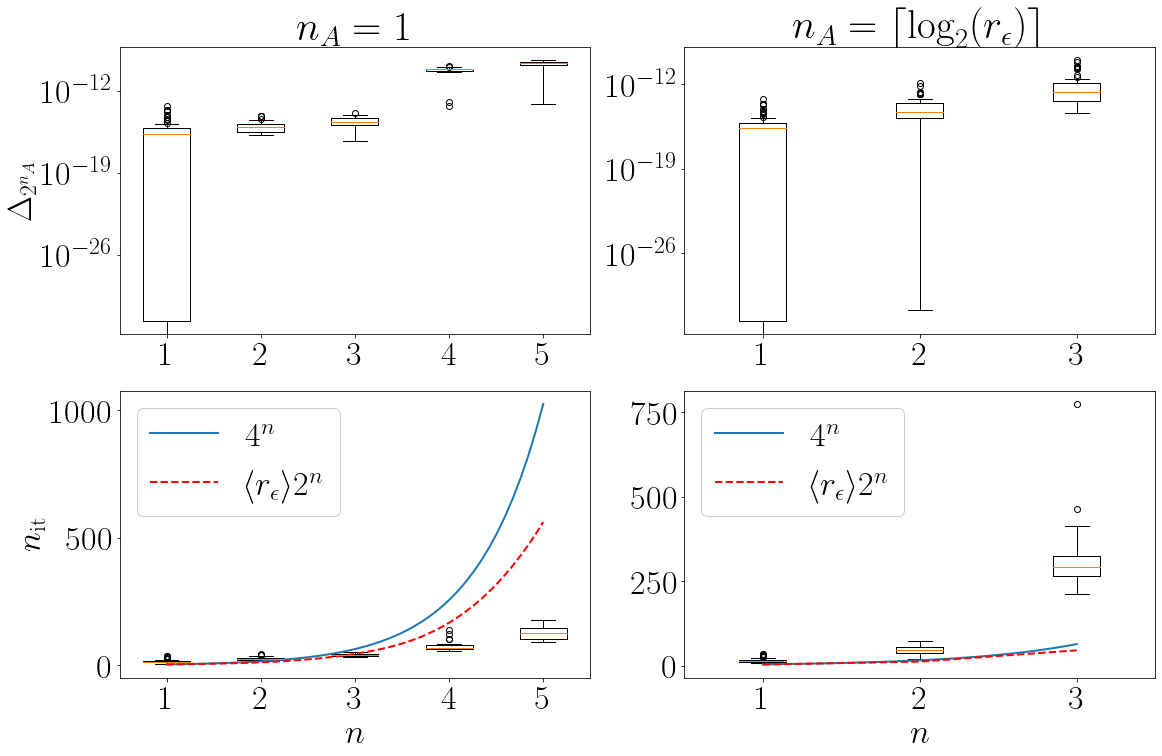

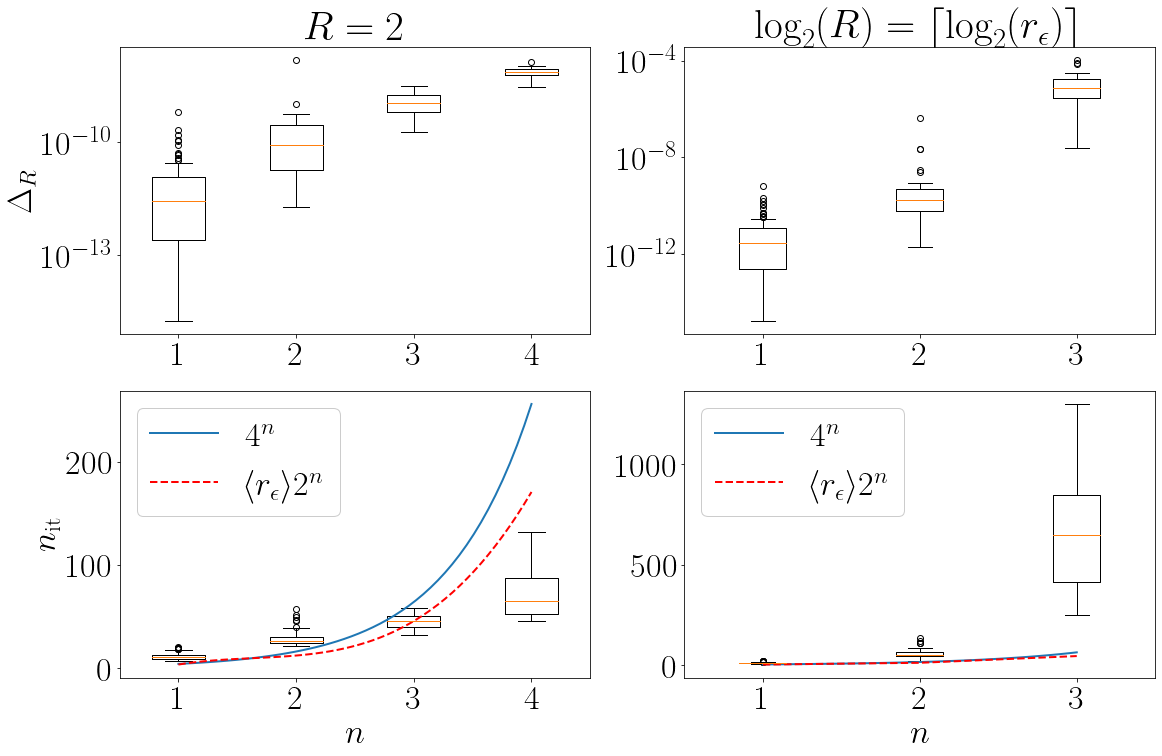

In [4]:
data_dir = "numerical_experiment_data"
fnames = glob.glob(f"{data_dir}/*.csv")

# create data dictionaries for the two types of ensembles
bures_data = {}
xy_data = {}
for fname in fnames:
    # parse data
    csv_data = []
    with open(fname, 'r') as f:
        f.readline()
        for line in f.readlines():
            csv_data.append(line)
    # ansatz type
    a_type = None
    if "VCCA" in fname or "CCPS" in fname:
        a_type = "CCPS"
    elif "VPSA" in fname:
        a_type = "VSPA"
    # determine ns
    split = fname.split("_")
    ns_idx = split.index("ns")
    ns = int(split[ns_idx + 1])
    # determine if bures or XY
    if "bures" in fname:
        key = (a_type, ns)
        if key in bures_data:
            bures_data[key] += csv_data
        else:
            bures_data[key] = csv_data
    elif "xy" in fname:
        # get temperature
        T_idx = split.index("T")
        T = float(split[T_idx + 1])
        key = (a_type, ns, T)
        if key in xy_data:
            xy_data[key] += csv_data
        else:
            xy_data[key] = csv_data

            
############################
## SP ansatz
############################
n_vals = list(range(1, 6))
a_type = "VSPA"
data_dict = {}
for n in n_vals:
    str_data = bures_data[(a_type, n)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    data = data_dict[n]
    na, re, diffs, num_it, num_f = data
    re_vals.append(re)
    low_rank_idxs = na == 1
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = 2**na >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    
plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel(r" $\Delta_{2^{n_A}}$")
ax[(0,0)].set_title(r"$n_A = 1$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 5), 4**(np.linspace(1,5)), label=r"$4^n$")
x = [1, 2, 3, 4, 5]
y = [np.mean(re_vals[j]) * 2**(x[j]) for j in range(5)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
#ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs[0:3])
ax[(0,1)].set_xticklabels(n_vals[0:3])
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$n_A = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it[0:3])
ax[(1,1)].set_xticklabels(n_vals[0:3])
ax[(1,1)].plot(np.linspace(1, 3), 4**(np.linspace(1, 3)), label=r"$4^n$")
x = [1, 2, 3]
y = [np.mean(re_vals[j]) * 2**(x[j]) for j in range(3)]
#x_new = np.linspace(x[0], x[-1], 50)
#bspline = interpolate.make_interp_spline(x, y)
#y_new = bspline(x_new)
ax[(1,1)].plot(x, y, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/bures_{a_type}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


############################
## CCPS ansatz
############################
n_vals = list(range(1, 5))
a_type = "CCPS"
data_dict = {}
for n in n_vals:
    str_data = bures_data[(a_type, n)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            #print(sl)
            #print(j, nd, n)
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    if data.size > 0:
        _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
        diffs = np.abs(dhs - opt_dhs)
        data_dict[n] = (na, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    try:
        data = data_dict[n]
        R, re, diffs, num_it, num_f = data
        re_vals.append(re)
        low_rank_idxs = R == 2
        low_rank_diffs.append(diffs[low_rank_idxs])
        low_rank_it.append(num_it[low_rank_idxs])
        high_rank_idxs = R >= re
        high_rank_diffs.append(diffs[high_rank_idxs])
        high_rank_it.append(num_it[high_rank_idxs])
    except:
        low_rank_diffs.append([1e-5])
        low_rank_it.append([10])
        high_rank_diffs.append([1e-5])
        high_rank_it.append([10])

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_{R}$")
ax[(0,0)].set_title(r"$R = 2$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 4), 4**(np.linspace(1,4)), label=r"$4^n$")
x = [1, 2, 3, 4]
y = [np.mean(re_vals[j]) * 2**(x[j]) for j in range(4)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
ax[(1,0)].legend()
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs[0:3])
ax[(0,1)].set_xticklabels(n_vals[0:3])
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$\log_2(R) = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it[0:3])
ax[(1,1)].set_xticklabels(n_vals[0:3])
ax[(1,1)].plot(np.linspace(1, 3), 4**(np.linspace(1, 3)), label=r"$4^n$")
x = [1, 2, 3]
y = [np.mean(re_vals[j]) * 2**(x[j]) for j in range(3)]
#x_new = np.linspace(x[0], x[-1], 50)
#bspline = interpolate.make_interp_spline(x, y)
#y_new = bspline(x_new)
ax[(1,1)].plot(x, y, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/bures_{a_type}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

In [5]:
bures_data.keys()

dict_keys([('CCPS', 2), ('VSPA', 1), ('CCPS', 4), ('VSPA', 2), ('CCPS', 1), ('VSPA', 4), ('CCPS', 5), ('CCPS', 3), ('VSPA', 5), ('VSPA', 3)])

# XY Data Plots

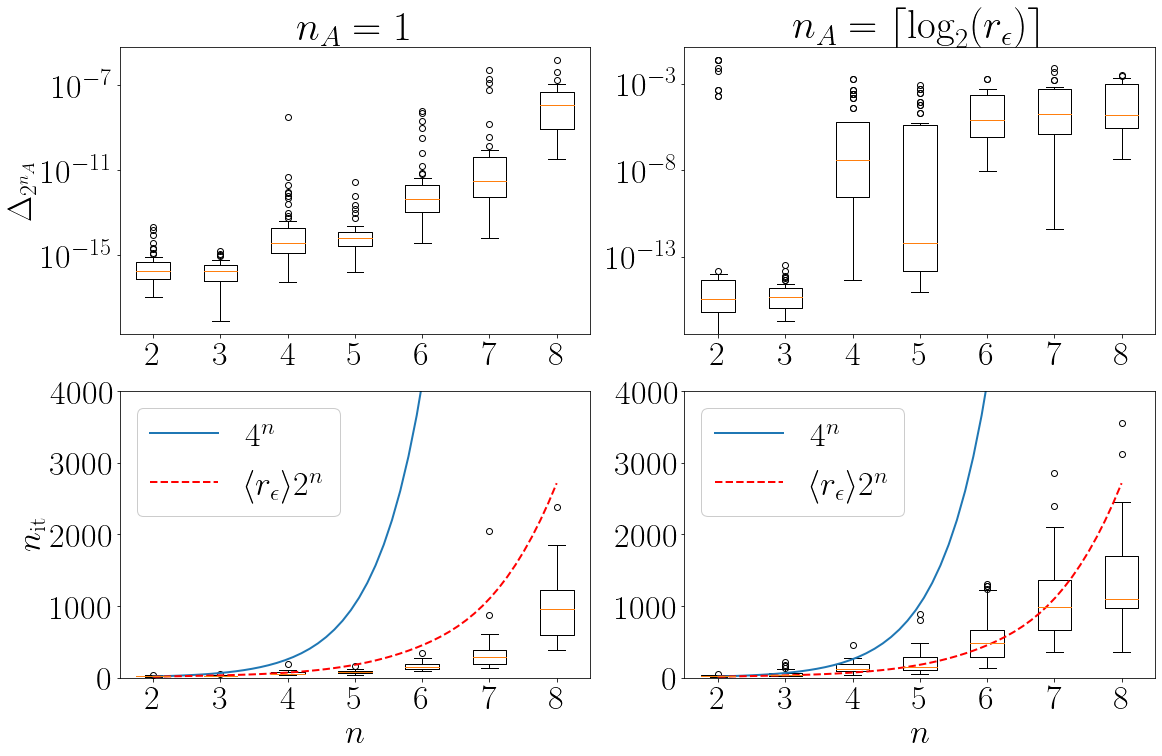

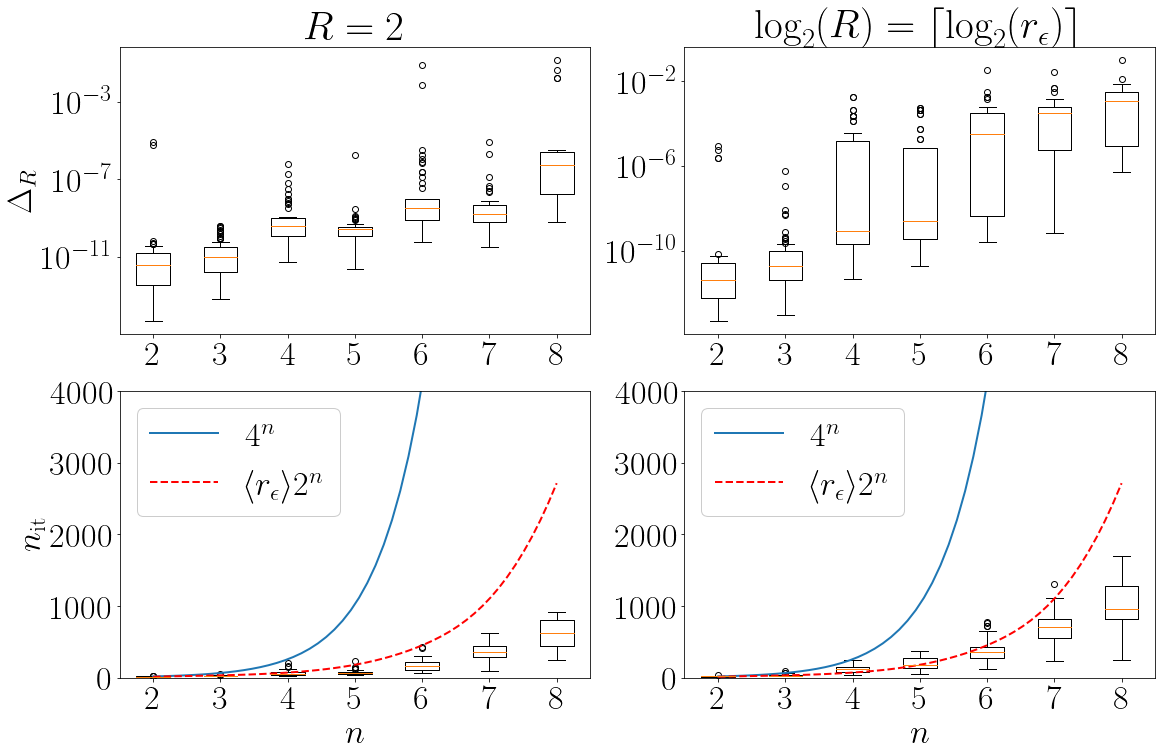

In [12]:
############################
## SP ansatz
############################

a_type = "VSPA"
T = 0.05
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)
    
T = 0.5
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    data = data_dict[n]
    na, re, diffs, num_it, num_f = data
    re_vals.append(re)
    low_rank_idxs = na == 1
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = 2**na >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_{2^{n_A}}$")
ax[(0,0)].set_title(r"$n_A = 1$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,0)].scatter(x, y, c='r')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$n_A = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,1)].scatter(x, y, c='r')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


############################
## CCPS ansatz
############################
a_type = "CCPS"
T = 0.05
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
T = 0.5
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
for n in n_vals:
    data = data_dict[n]
    R, re, diffs, num_it, num_f = data
    low_rank_idxs = R == 2
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = R >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_R$")
ax[(0,0)].set_title(r"$R = 2$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$\log_2(R) = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

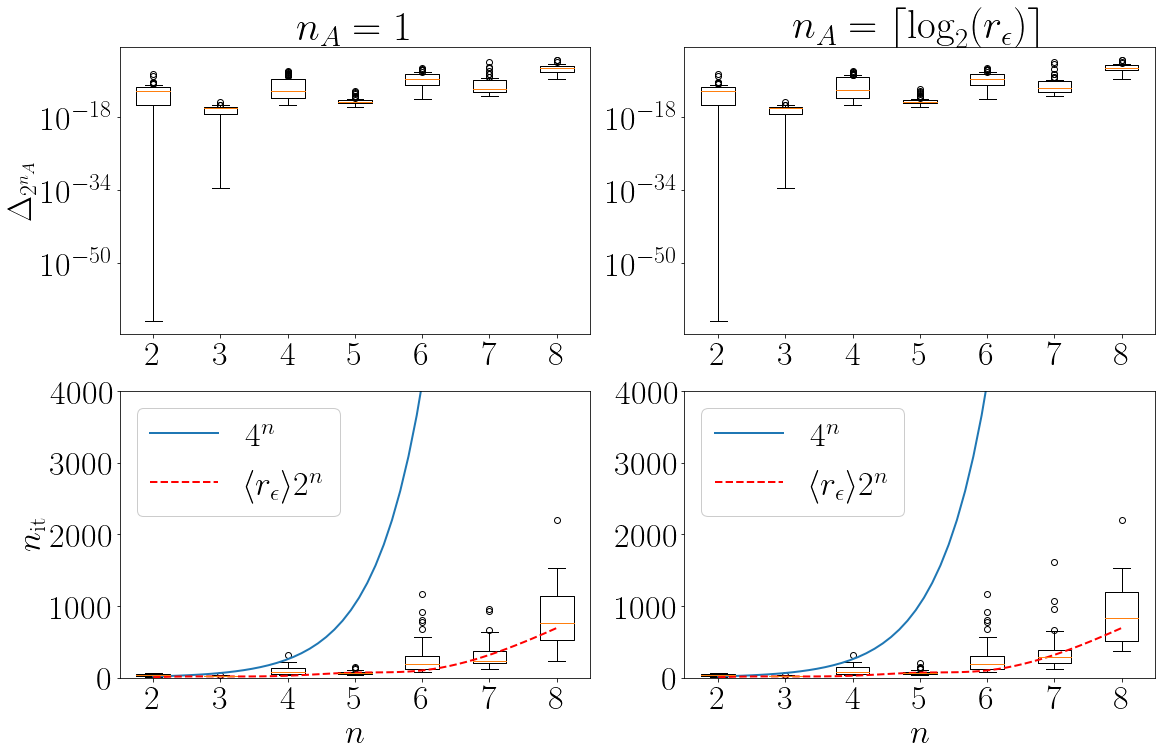

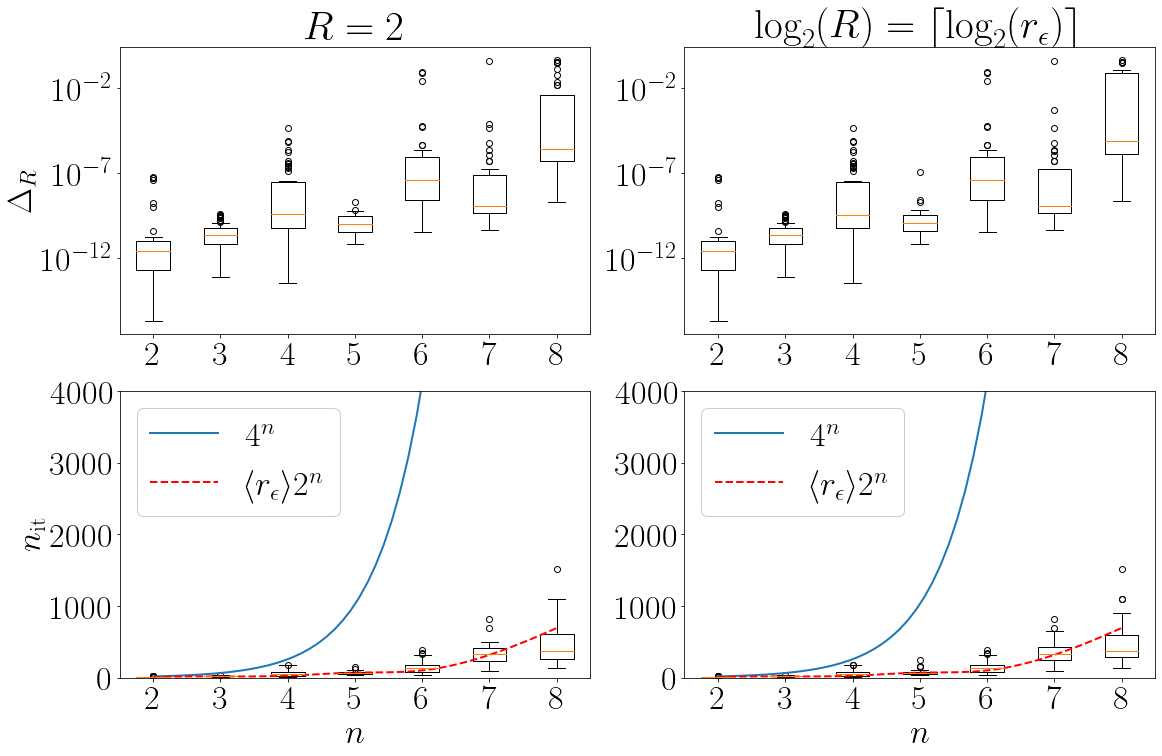

In [13]:
############################
## SP ansatz
############################

a_type = "VSPA"
T = 0.05
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    data = data_dict[n]
    na, re, diffs, num_it, num_f = data
    re_vals.append(re)
    low_rank_idxs = na == 1
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = 2**na >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_{2^{n_A}}$")
ax[(0,0)].set_title(r"$n_A = 1$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,0)].scatter(x, y, c='r')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$n_A = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,1)].scatter(x, y, c='r')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_T_{T}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


############################
## CCPS ansatz
############################
a_type = "CCPS"
T = 0.05
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
for n in n_vals:
    data = data_dict[n]
    R, re, diffs, num_it, num_f = data
    low_rank_idxs = R == 2
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = R >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_R$")
ax[(0,0)].set_title(r"$R = 2$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$\log_2(R) = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_T_{T}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

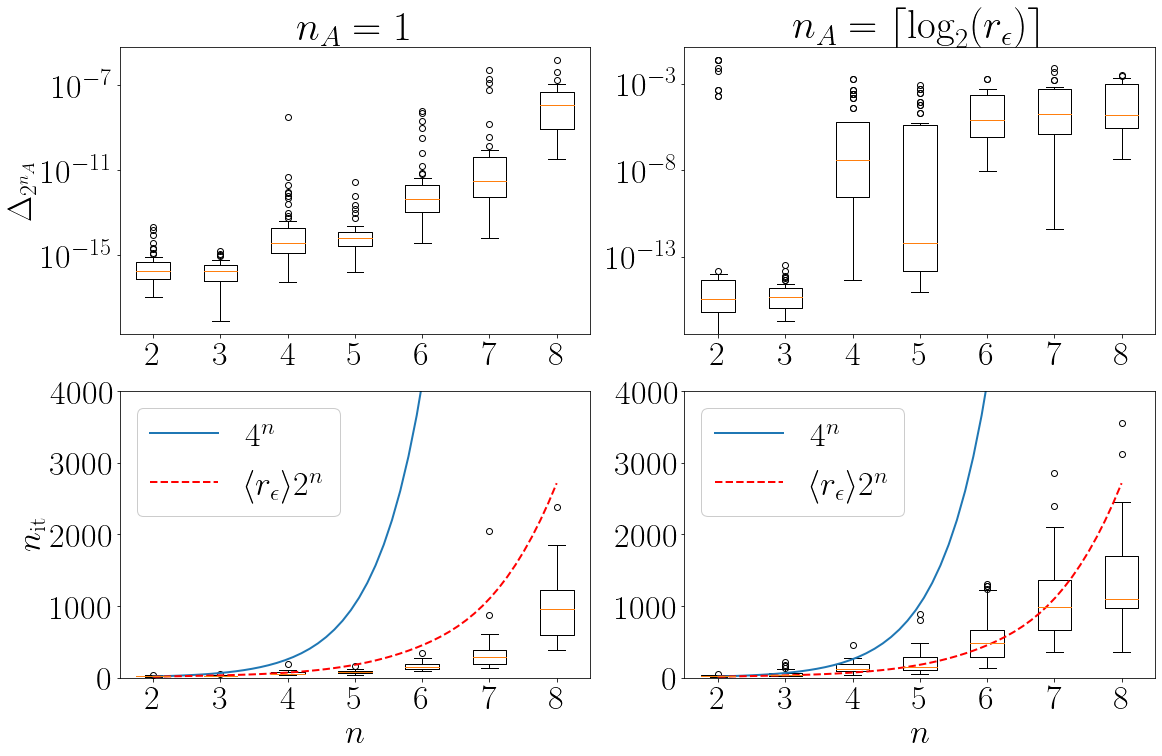

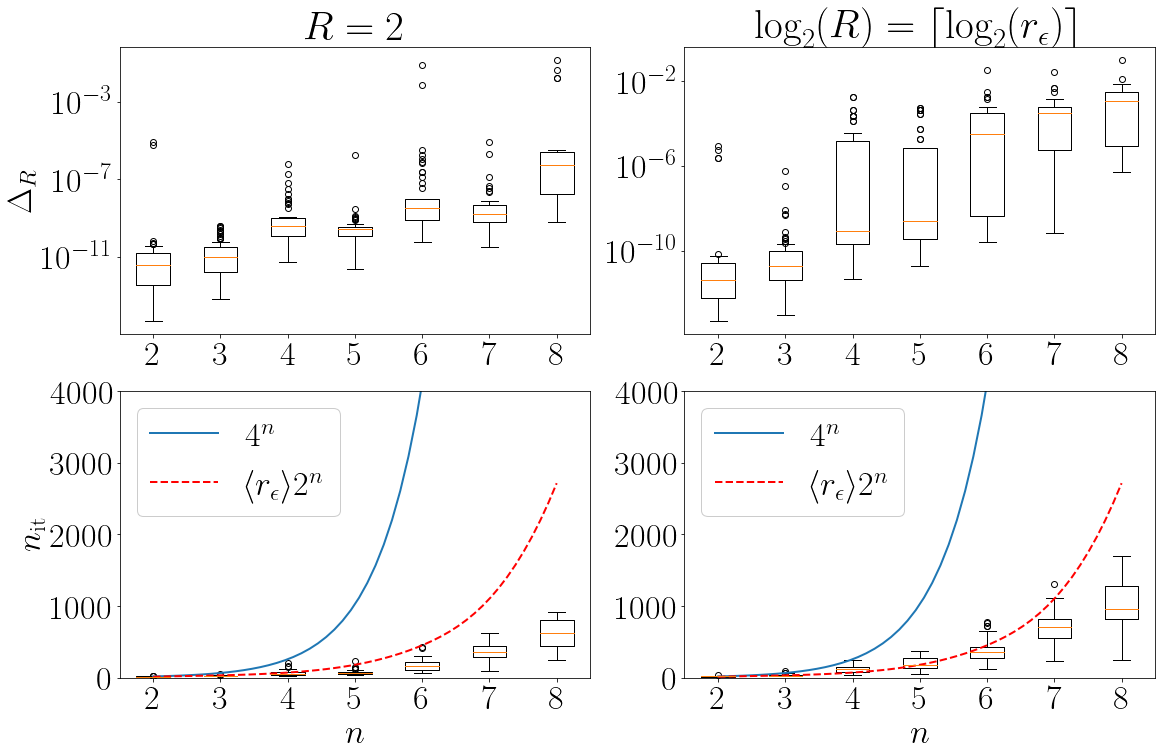

In [14]:
############################
## SP ansatz
############################
T = 0.50

a_type = "VSPA"
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    data = data_dict[n]
    na, re, diffs, num_it, num_f = data
    re_vals.append(re)
    low_rank_idxs = na == 1
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = 2**na >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_{2^{n_A}}$")
ax[(0,0)].set_title(r"$n_A = 1$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,0)].scatter(x, y, c='r')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$n_A = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,1)].scatter(x, y, c='r')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_T_{T}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


############################
## CCPS ansatz
############################
a_type = "CCPS"
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
for n in n_vals:
    data = data_dict[n]
    R, re, diffs, num_it, num_f = data
    low_rank_idxs = R == 2
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = R >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_R$")
ax[(0,0)].set_title(r"$R = 2$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$\log_2(R) = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_T_{T}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

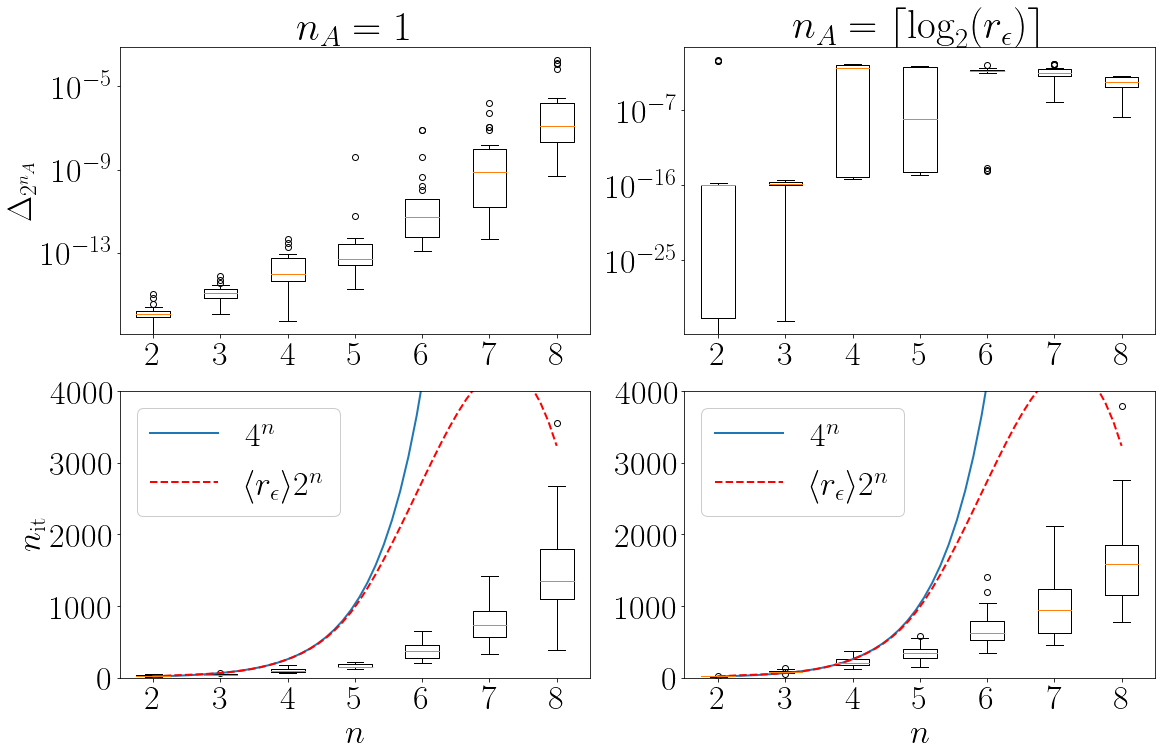

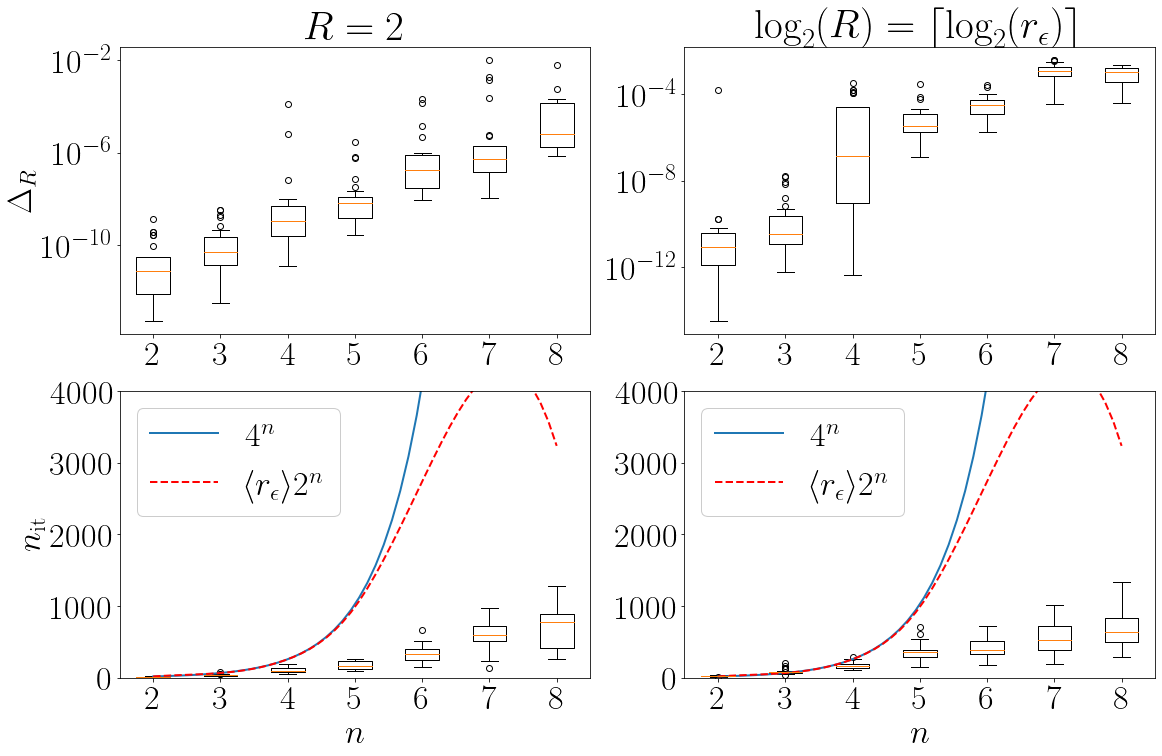

In [15]:
############################
## SP ansatz
############################
T = 5.00

a_type = "VSPA"
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    data = data_dict[n]
    na, re, diffs, num_it, num_f = data
    re_vals.append(re)
    low_rank_idxs = na == 1
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = 2**na >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_{2^{n_A}}$")
ax[(0,0)].set_title(r"$n_A = 1$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,0)].scatter(x, y, c='r')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$n_A = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,1)].scatter(x, y, c='r')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_T_{T}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


############################
## CCPS ansatz
############################
a_type = "CCPS"
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
for n in n_vals:
    data = data_dict[n]
    R, re, diffs, num_it, num_f = data
    low_rank_idxs = R == 2
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = R >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_R$")
ax[(0,0)].set_title(r"$R = 2$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$\log_2(R) = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_T_{T}_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

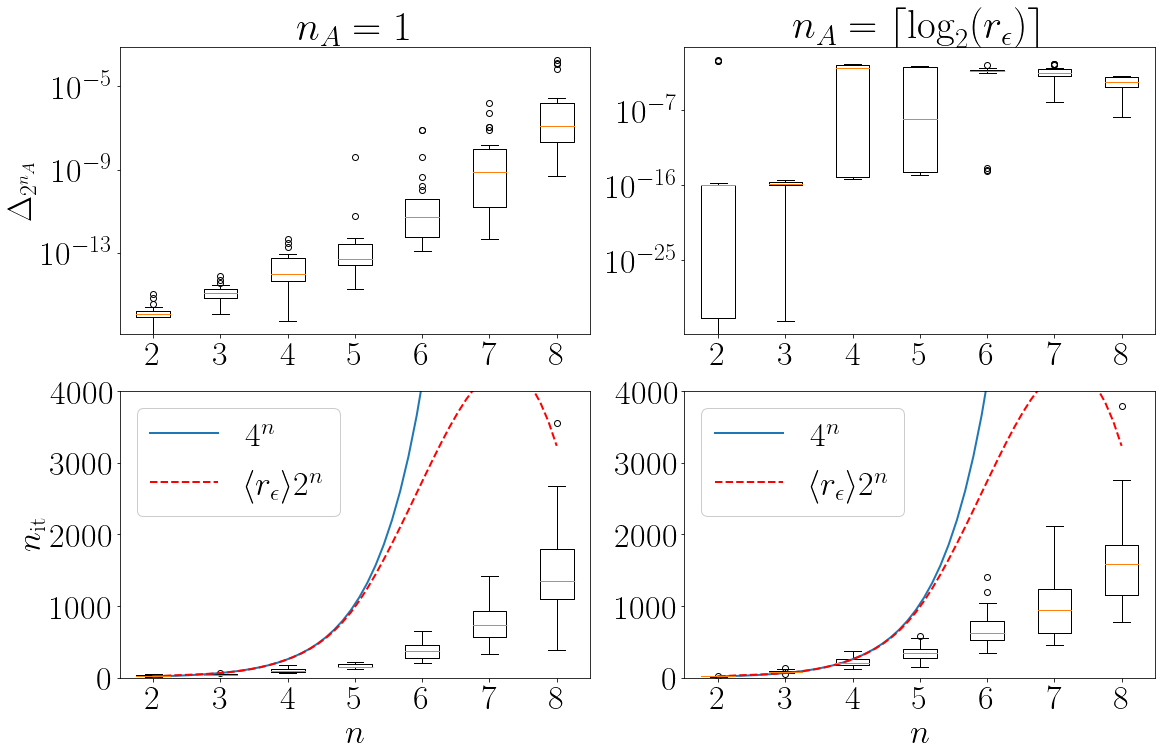

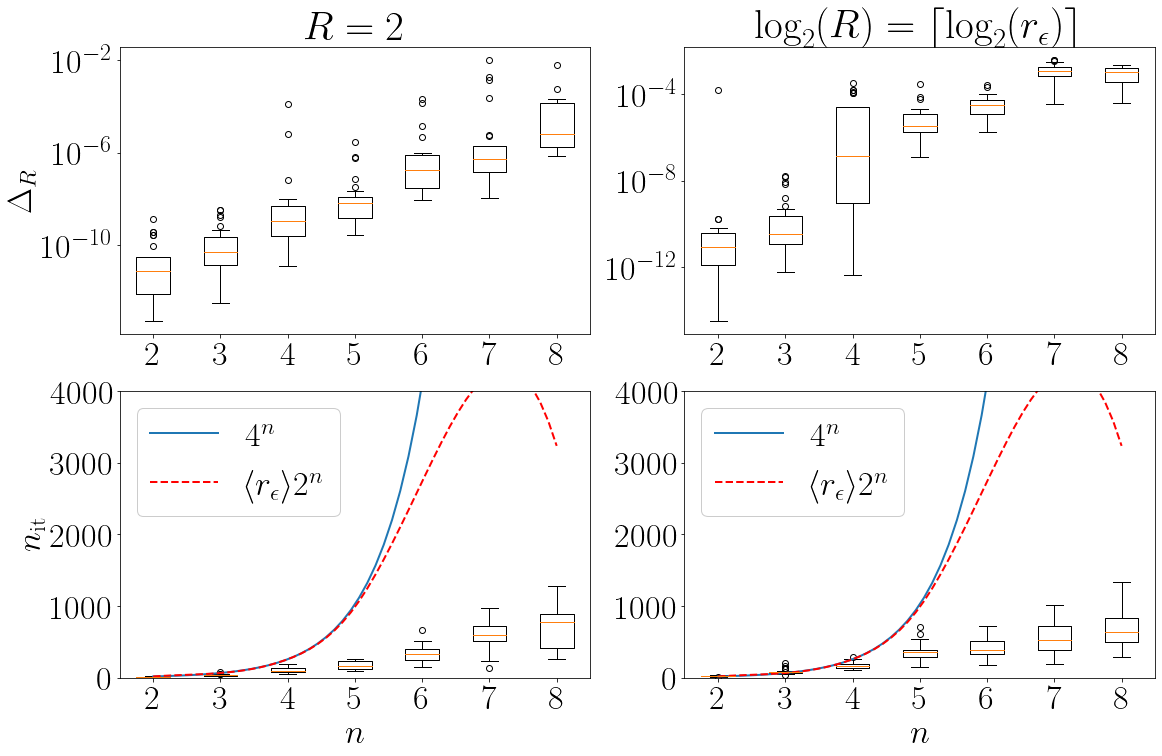

In [16]:
############################
## SP ansatz
############################

a_type = "VSPA"
T = 0.05
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)
    
T = 0.5
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, na, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (na, re, diffs, num_it, num_f)
    
T = 5.0
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)

low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
re_vals = []
for n in n_vals:
    data = data_dict[n]
    na, re, diffs, num_it, num_f = data
    re_vals.append(re)
    low_rank_idxs = na == 1
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = 2**na >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_{2^{n_A}}$")
ax[(0,0)].set_title(r"$n_A = 1$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,0)].scatter(x, y, c='r')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$n_A = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
#ax[(1,1)].scatter(x, y, c='r')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_all_T_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


############################
## CCPS ansatz
############################
a_type = "CCPS"
T = 0.05
n_vals = list(range(2, 9))
data_dict = {}
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
T = 0.5
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
T = 5.0
for n in n_vals:
    str_data = xy_data[(a_type, n, T)]
    data = []
    for line in str_data:
        sl = line.split(",")
        new_data = []
        for j, nd in enumerate(sl):
            if j in [0, 1, 3, 4, 7, 8, 9]:
                new_data.append(int(nd))
            else:
                new_data.append(float(nd))
        data.append(new_data)
    data = np.array(data)
    _, _, _, re, R, dhs, opt_dhs, num_it, num_f, _ = np.transpose(data)
    diffs = np.abs(dhs - opt_dhs)
    data_dict[n] = (R, re, diffs, num_it, num_f)
    
low_rank_diffs = []
low_rank_it = []
high_rank_diffs = []
high_rank_it = []
for n in n_vals:
    data = data_dict[n]
    R, re, diffs, num_it, num_f = data
    low_rank_idxs = R == 2
    low_rank_diffs.append(diffs[low_rank_idxs])
    low_rank_it.append(num_it[low_rank_idxs])
    high_rank_idxs = R >= re
    high_rank_diffs.append(diffs[high_rank_idxs])
    high_rank_it.append(num_it[high_rank_idxs])
    

plt.rcParams['font.size'] = 34
    

ysize = 5.8 * 2
fig, ax = plt.subplots(2, 2, figsize=(1.6*ysize, ysize))
# low rank plots
ax[(0,0)].boxplot(low_rank_diffs)
ax[(0,0)].set_xticklabels(n_vals)
ax[(0,0)].set_yscale("log")
ax[(0,0)].set_ylabel("$\Delta_R$")
ax[(0,0)].set_title(r"$R = 2$")
ax[(1,0)].boxplot(low_rank_it)
ax[(1,0)].set_xticklabels(n_vals)
ax[(1,0)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,0)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,0)].set_ylim(0, 4000)
ax[(1,0)].legend()
#ax[(1,0)].set_yscale("log")
ax[(1,0)].set_ylabel("$n_{\\text{it}}$")
ax[(1,0)].set_xlabel(r"$n$")
# high rank plots
ax[(0,1)].boxplot(high_rank_diffs)
ax[(0,1)].set_xticklabels(n_vals)
ax[(0,1)].set_yscale("log")
ax[(0,1)].set_title(r"$\log_2(R) = \lceil \log_2(r_\epsilon) \rceil$")
ax[(1,1)].boxplot(high_rank_it)
ax[(1,1)].set_xticklabels(n_vals)
ax[(1,1)].plot(np.linspace(1, 7), 4**(np.linspace(2, 8)), label=r"$4^n$")
x = [1, 2, 3, 4, 5, 6, 7]
y = [np.mean(re_vals[j]) * 2**(n_vals[j]) for j in range(7)]
x_new = np.linspace(x[0], x[-1], 50)
bspline = interpolate.make_interp_spline(x, y)
y_new = bspline(x_new)
ax[(1,1)].plot(x_new, y_new, label=r"$\langle r_\epsilon \rangle 2^n$", c='r', linestyle='dashed')
ax[(1,1)].set_ylim(0, 4000)
ax[(1,1)].legend()
#ax[(1,1)].set_yscale("log")
ax[(1,1)].set_xlabel(r"$n$")
plt.savefig(f"plots/xy_{a_type}_all_T_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

# Plot Hardware data

## random 1 qubit state plot (SP and CCPS)

In [11]:
def compute_optimal_DHS(rho, R):
    """
    Computes D^*_HS when learning [rho]
    with a rank [R] approximation.
    """
    # compute \lambda's and sort them
    lam = np.sort(np.real(np.linalg.eigvals(rho)))
    d = len(lam)
    # compute lowest d - R lowest and R highest
    low_lam = np.array(lam[0:d-R])
    high_lam = np.array(lam[d-R:])
    N = (1 - np.sum(high_lam)) / R
    # compute cost
    #opt_DHS = np.sum(low_lam) + (1/R) * (1 - np.sum(high_lam))**2
    opt_DHS = np.sum(low_lam**2) +  R * N**2
    
    return opt_DHS

def get_rolling_mins(costs, window=10):
    """
    Gets the minimum value fo the cost at every window.
    """
    mins = []
    bins = int(np.floor(len(costs) / window))
    for b in range(bins):
        cost_window = costs[b * window:(b + 1) * window]
        mins.append(min(cost_window))
        
    cost_window = costs[(bins) * window:]
    if len(cost_window) > 0:
        mins.append(min(cost_window))
    
    return np.array(mins)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ddir = "pub_hardware_data/random_state_SP_ansatz"

sp_R2_shot_cost = []
sp_R2_exact_cost = []
with open(f"{ddir}/date_20210920-121535_nqubit_1_hardware_ibmq_casablanca_MSL_haar_atype_hef2d_opt_BFGS.csv", 'r') as f:
    f.readline()
    for l in f.readlines():
        shot, exact, = l.split(",")
        sp_R2_shot_cost.append(float(shot))
        sp_R2_exact_cost.append(float(exact))
        
        
# must generate rho from the parameters of the circuit
R1_rho_params = [6.12073495, 1.16120667, 3.38216267, 3.49973899, 1.8877114, 3.77717022,
 1.57383566, 0.656488,   3.68852582, 2.96791314, 2.84928064, 3.38561463,
 5.38226244, 0.30773205, 2.14503341]
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R1_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
R1_rho = qiskit.quantum_info.partial_trace(psi, [0])
R1_opt = compute_optimal_DHS(R1_rho, 1)

ddir = "pub_hardware_data/aliza_hardware_data"
ccps_R1_shot_cost = []
with open(f"{ddir}/rank_1_shot_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R1_shot_cost.append(float(l))
        
ccps_R1_exact_cost = []
with open(f"{ddir}/rank_1_exact_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R1_exact_cost.append(float(l))
        
R2_rho_params = [3.18893189, 6.27124987, 2.22112546, 1.47919731, 0.87348005, 2.96821423,
 6.10530066, 3.79836755, 6.11363481, 5.52379821, 1.69065155, 5.11802006,
 5.74336996, 4.01688969, 5.67435184]
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R2_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
R2_rho = qiskit.quantum_info.partial_trace(psi, [0])
R2_opt = compute_optimal_DHS(R2_rho, 2)

ccps_R2_shot_cost = []
with open(f"{ddir}/rank_2_shot_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R2_shot_cost.append(float(l))
        
ccps_R2_exact_cost = []
with open(f"{ddir}/rank_2_exact_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R2_exact_cost.append(float(l))
        
width = 8
fig = plt.figure(figsize=(1.6 * width, width))
c = colors[0]
sp_p1, = plt.plot(get_rolling_mins(np.abs(sp_R2_shot_cost), 1), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
sp_p2, = plt.plot(get_rolling_mins(np.abs(sp_R2_exact_cost), 1), label=r"$C_{\text{noiseless}}$", color=c)

plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"$n_{\text{it}}$")
plt.rcParams['legend.title_fontsize'] = 'x-small'

c = colors[1]
ccps_p1, = plt.plot(get_rolling_mins(ccps_R2_shot_cost, 4), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
ccps_p2, = plt.plot(get_rolling_mins(ccps_R2_exact_cost, 4), label=r"$C_{\text{noiseless}}$", color=c)

plt.rcParams['legend.title_fontsize'] = 'x-small'
legend1 = plt.legend(handles=[sp_p1, sp_p2], fontsize="x-small", title="SP, $n_A = 1$", loc=3)
plt.gca().add_artist(legend1)
legend2 = plt.legend(handles=[ccps_p1, ccps_p2], fontsize="x-small", title="CCPS, R = 2", loc=1)
plt.gca().add_artist(legend2)


plt.savefig("plots/random_1q_hardware_results.pdf", dpi=800, bbox_inches = 'tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'pub_hardware_data/random_state_SP_ansatz/date_20210920-121535_nqubit_1_hardware_ibmq_casablanca_MSL_haar_atype_hef2d_opt_BFGS.csv'

## hardware-induced state plots (SP and CCPS)

In [ ]:
ddir1 = "pub_hardware_data/hardware_state_CCPS_ansatz"
csv_files1 = glob.glob(f"{ddir1}/csv_runs/*")
pkl_files1 = glob.glob(f"{ddir1}/pickled_runs/*")

ddir2 = "pub_hardware_data/hardware_state_SP_ansatz"
csv_files2 = glob.glob(f"{ddir2}/csv_runs/*")
pkl_files2 = glob.glob(f"{ddir2}/pickled_runs/*")

csv_files = csv_files1 + csv_files2
pkl_files = pkl_files1 + pkl_files2

csv_files = [csv_files[0], csv_files[2], csv_files[4]]

def make_data_dict(csv_files, pkl_files):
    """
    Makes a data dictionary for plotting purposes.
    """
    data_dict = {}
    for file in csv_files:
        # load in csv info
        shot_cost = []
        exact_cost = []
        with open(file, 'r') as f:
            for line in f.readlines():
                sc, ec = [float(z) for z in line.strip('\n').split(',')]
                shot_cost.append(sc)
                exact_cost.append(ec)
        # get associated pkl file with states/ metadata
        pkl_dir = "/".join(file.split("/")[0:2])+ "/pickled_runs/"
        pkl_f = file.split('/')[3][0:-4] + ".pkl"
        with open(pkl_dir + pkl_f, 'rb') as f:
            meta_data = pickle.load(f)
            rho = meta_data['rho']
            sigma = meta_data['sigma']
            num_params = meta_data['num_ansatz_params']

        data_dict[pkl_f[0:-4]] = [shot_cost, exact_cost, rho, sigma, num_params]
        
    return data_dict

data_dict = make_data_dict(csv_files, pkl_files)

R = 2
R2_shot, R2_exact, R2_rho, R2_sigma, R2_np = data_dict["belem_1q_hadamard_prep_run"]
R2_opt = compute_optimal_DHS(R2_rho, R)

R = 1
R1_shot, R1_exact, R1_rho, R1_sigma, R1_np = data_dict["belem_1q_hadamard_prep_run_rank1_approx"]
R1_opt = compute_optimal_DHS(R1_rho, R)

R = 4
R4_shot, R4_exact, R4_rho, R4_sigma, R4_np = data_dict["jakarta_2q_ghz_prep_run_rank_4_approx"]
R4_opt = compute_optimal_DHS(R4_rho, R)

# extract eigenvalues/ eigenvectors
sig_p, sig_v = np.linalg.eigh(R4_sigma)
p0 = sig_p[0]
v0 = sig_v[:,0]
p1 = sig_p[1]
v1 = sig_v[:,1]
p2 = sig_p[2]
v2 = sig_v[:,2]
p3 = sig_p[3]
v3 = sig_v[:,3]

width = 8
fig = plt.figure(figsize=(1.6 * width, width))
c = colors[0]
#plt.plot(get_rolling_mins(R1_shot, R1_np) + (1.02 - np.real(R1_rho.purity())), label=r"$C_{shot}, R=1$", color=c, linestyle=":", linewidth=2.5)
#R1_shot = list(np.abs(R1_shot))
#plt.plot(np.abs(get_rolling_mins(R1_shot, R1_np)), label=r"$C_{shot}, R=1$", color=c, linestyle=":", linewidth=2.5)
#plt.plot(get_rolling_mins(R1_exact, R1_np), label=r"$C_{noiseless}, R=1$", color=c)
#plt.axhline(R1_opt, 0, 10, label=r"$C^*, R = 1$", color=c, linestyle="-.")
#c = colors[1]
#R2_shot = list(np.abs(R2_shot))
sp_plus_R2_1, = plt.plot(np.abs(get_rolling_mins(R2_shot, R2_np)), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
sp_plus_R2_2, = plt.plot(get_rolling_mins(R2_exact, R2_np), label=r"$C_{\text{noiseless}}$", color=c)

c = colors[1]
R4_shot = list(np.abs(R4_shot))
ccps_phi_R4_1, = plt.plot(get_rolling_mins(R4_shot, 10)[2:], label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
ccps_phi_R4_2, = plt.plot(get_rolling_mins(R4_exact, 10)[2:], label=r"$C_{\text{noiseless}}$", color=c)

plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"$n_{\text{it}}$")

plt.rcParams['legend.title_fontsize'] = 'x-small'
legend1 = plt.legend(handles=[sp_plus_R2_1, sp_plus_R2_2], fontsize="x-small", title="SP, $n_A = 1, \Tilde{\\rho}_+$", loc=3)
plt.gca().add_artist(legend1)
legend2 = plt.legend(handles=[ccps_phi_R4_1, ccps_phi_R4_2], fontsize="x-small", title="CCPS, $R = 4, \Tilde{\\rho}_{\Phi_+}$", loc=1)
plt.gca().add_artist(legend2)

plt.savefig("plots/noise_induced_state_results.pdf", dpi=800, bbox_inches = 'tight')
plt.show()

# Make PCA Plots

In [ ]:
data_dir = "./pca_data"
fnames = glob.glob(f"{data_dir}/*VCCA*.pkl")

full_data = {}
for fn in fnames:
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        for key, value in data.items():
            full_data[key] = value
            
def compute_optimal_DHS_and_trace(rho, R):
    """
    Computes D^*_HS when learning [rho]
    with a rank [R] approximation.
    """
    # compute \lambda's and sort them
    lam = np.sort(np.real(np.linalg.eigvals(rho)))
    d = len(lam)
    # compute lowest d - R lowest and R highest
    low_lam = np.array(lam[0:d-R])
    high_lam = np.array(lam[d-R:])
    N = (1 - np.sum(high_lam)) / R
    # compute optimal HS cost
    opt_DHS = np.sum(low_lam**2) +  R * N**2
    # compute optimal trace dist
    tr_dist = (1/2) * np.sum(low_lam)
        
    return opt_DHS, tr_dist

ns = 3
T = 0.05

delta = []
opt_hs_dist = [[] for _ in range(2**ns - 1)]
opt_tr_dist = [[] for _ in range(2**ns - 1)]
found_tr_dist = [[] for _ in range(2**ns)]
found_hs_dist = [[] for _ in range(2**ns)]
low_rank_infid = [[] for _ in range(2)]
high_rank_infid = [[] for _ in range(2**ns)]
high_rank_pk = [[] for _ in range(2**ns)]
high_rank_qk = [[] for _ in range(2**ns)]
for sidx in range(24):
    pat = f"rho_ns_{ns}_T_{T}*_sidx_{sidx}"
    for key in full_data.keys():
        if fnmatch.fnmatch(key, pat):
            # extract re and R from key
            s_key = key.split("_")
            re_idx = s_key.index("re") + 1
            re = int(s_key[re_idx])
            R_idx = s_key.index("R") + 1
            R = int(s_key[R_idx])
            # extract rho and diagonlize it
            rho = full_data[key]
            rho_p, rho_v = np.linalg.eigh(rho)
            rho_R_pc = []
            d = int(2**ns)
            for k in range(R):
                phik = rho_v[:,d - 1 - k]
                rho_R_pc.append(phik)

            opt_dhs = full_data[f"optDHS_{key[4:]}"]
            num_dhs = full_data[f"costs_{key[4:]}"][-1]
            delta.append(num_dhs - opt_dhs)
            
            for Rk in range(1, d):
                opt_dhs, opt_tr = compute_optimal_DHS_and_trace(rho, Rk)
                opt_hs_dist[Rk - 1].append(opt_dhs)
                opt_tr_dist[Rk - 1].append(opt_tr)
            
            sigma_p = []
            sigma_v = []
            for k in range(R):
                pk_key = f"p_{key[4:]}_{k}"
                pk = full_data[pk_key]
                sigma_p.append(pk)
                psi_key = f"psi_{key[4:]}_{k}"
                psik = full_data[psi_key]
                sigma_v.append(psik)
            
            #print(f"sidx: {sidx}")
            for idx, k in enumerate(np.argsort(sigma_p)[::-1]):
                pk = sigma_p[k]
                #print(pk)
                psik = sigma_v[k]
                fk = max([qiskit.quantum_info.state_fidelity(rho_R_pc[j], psik) for j in range(R)])
                if R == 2 and R <= re:
                    low_rank_infid[idx].append(1 - fk)
                else:
                    high_rank_infid[idx].append(1 - fk)
                    high_rank_pk[idx].append(rho_p[d - 1 - idx])
                    high_rank_qk[idx].append(pk)
                    
            # also extract actually found trace distances
            idx_ordering = np.argsort(sigma_p)[::-1]
            probs = np.array(sigma_p)[idx_ordering]
            vecs = np.array(sigma_v)[idx_ordering]
            for R in range(1, 2**ns + 1):
                R_probs = np.array(probs[0:R])
                normed_diff = (1 - sum(R_probs)) / R
                R_probs += normed_diff
                sigma = R_probs[0] * qiskit.quantum_info.DensityMatrix(vecs[0])
                for j in range(1, R):
                    sigma += R_probs[j] * qiskit.quantum_info.DensityMatrix(vecs[j])
                tr_d = (0.5) * np.linalg.norm(rho - sigma, 1)
                found_tr_dist[R - 1].append(tr_d)
                hs_d = np.real(rho.purity() + sigma.purity() - 2 * np.trace(np.matmul(rho, sigma)))
                found_hs_dist[R - 1].append(hs_d)
                
height = 6
plt.rcParams["font.size"] = 32
fig = plt.figure(figsize=(1.62 * height, height))
plt.boxplot(high_rank_infid)
plt.yscale("log")
#plt.title(r"$\rho_3^{XY}(\beta = 2), R = 8$")
plt.ylabel(r"Infidelity, $1 - |\langle v_k | u_k \rangle |^2$")
plt.xlabel(r"$k^{\text{th}}$ principal component, $| v_k \rangle$")
plt.xticks(ticks=range(1, 9), labels=range(8))
plt.savefig(f"plots/pca_example_infidelity.pdf", dpi=800, bbox_inches='tight')
plt.show()

height = 6
plt.rcParams["font.size"] = 40
fig = plt.figure(figsize=(1.62 * height, height))
rho_eigvals = [np.median(x) for x in high_rank_pk][0:3]
rho_y_err = [2 * np.std(x) for x in high_rank_pk][0:3]
sigma_eigvals = [np.median(x) for x in high_rank_qk][0:3]
sigma_y_err = [2 * np.std(x) for x in high_rank_qk][0:3]
x_vals = np.array(range(8))[0:3]
plt.bar(x_vals, rho_eigvals, width=0.25, yerr=rho_y_err)
plt.bar(x_vals + 0.25, sigma_eigvals, width=0.25, yerr=sigma_y_err)
plt.xticks(ticks=x_vals + 0.125, labels=x_vals)
plt.ylabel(r"mean P.V.")
plt.xlabel(r"$k^{\text{th}}\  \text{P.V.}$")
plt.ylim(0, 1)
plt.legend([r"$\rho_{n=3}^{\beta=20}$", r"$\sigma(\boldsymbol{\alpha}^*, R=8)$"], loc=(0.325, 0.55))
plt.savefig(f"plots/xy_ensemble_PV_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

height = 6
plt.rcParams["font.size"] = 32
fig = plt.figure(figsize=(1.62 * height, height))
plt.boxplot(found_hs_dist[::-1], labels=[str(x) for x in list(range(1, 9))[::-1]])
plt.yscale("log")
plt.ylabel(r"$C(\boldsymbol{\alpha}^*, R = 8 \rightarrow R')$")
plt.xlabel(r"$R'$")
plt.savefig(f"plots/pca_example_costdist.pdf", dpi=800, bbox_inches='tight')
plt.show()

In [ ]:
eps_list = []
num_rank_2_list = []
for j in range(20):
    eps = 10**(-j)
    eps_list.append(eps)
    num_rank_2 = sum(np.array(high_rank_pk[2]) < eps) / len(high_rank_pk[2])
    num_rank_2_list.append(num_rank_2)
    
plt.scatter(eps_list, num_rank_2_list)
plt.xscale("log")

eps = 10**(-10)
num_rank_2 = sum(np.array(high_rank_pk[2]) < eps) / len(high_rank_pk[2])
print(num_rank_2)